In [1]:
%matplotlib inline
import numpy as np
import helpers_05_08
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.datasets import make_blobs, load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use("seaborn-whitegrid")

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_14511/2414357448.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


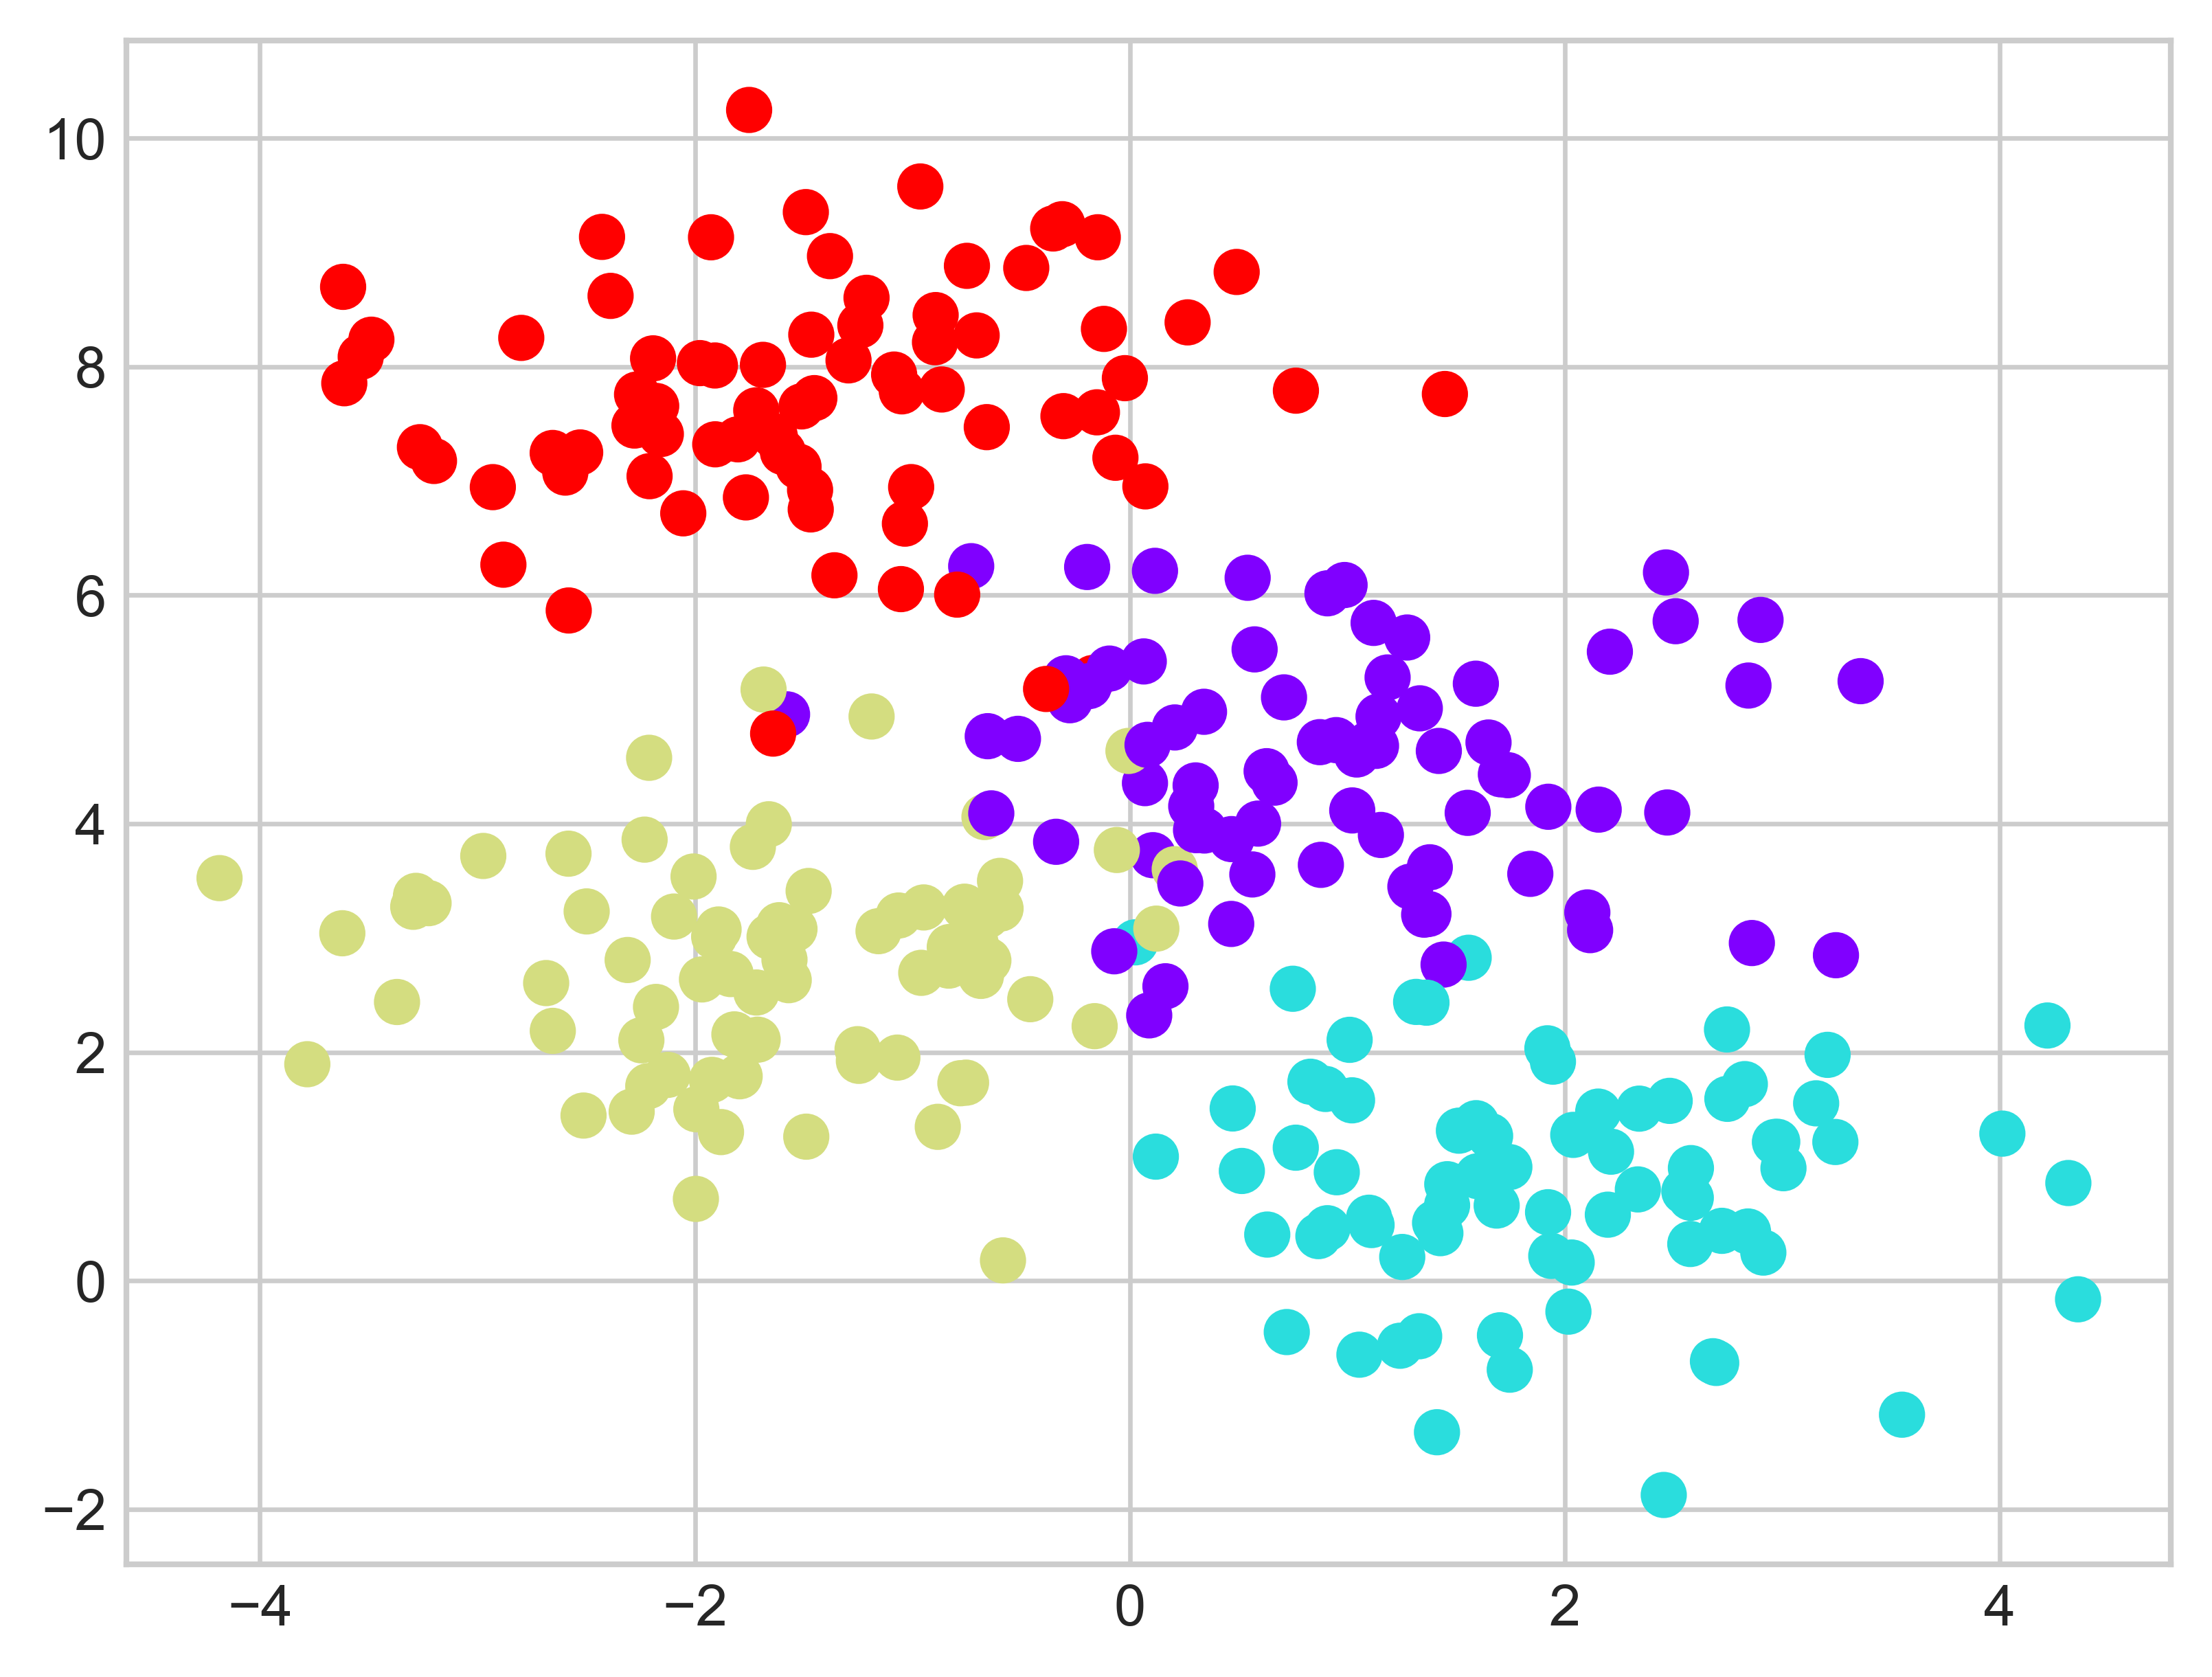

In [3]:
# random forests are an example of an ensemble learner built on decision trees
# decision trees aer extremely intuitive ways to classify or label objects you simply ask a series of questions designed to zero in on the classification. the binary splitting makes this extremely efficient each question should cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes. The hard part is deciding which questions to ask.
# consider the following two-dimensional data, which has one of four class labels:
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="rainbow")

In [4]:
# a simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion,
tree = DecisionTreeClassifier().fit(X, y)

In [5]:
# lets write a utility function to help us visualize the output of the classifier:
def visualize_classifier(model, X, y, ax=None, cmap="rainbow"):
    ax = ax or plt.gca()
    # Plot the training points
    ax.scatter(
        X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3
    )
    ax.axis("tight")
    ax.axis("off")
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(
        xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, zorder=1
    )
    ax.set(xlim=xlim, ylim=ylim)

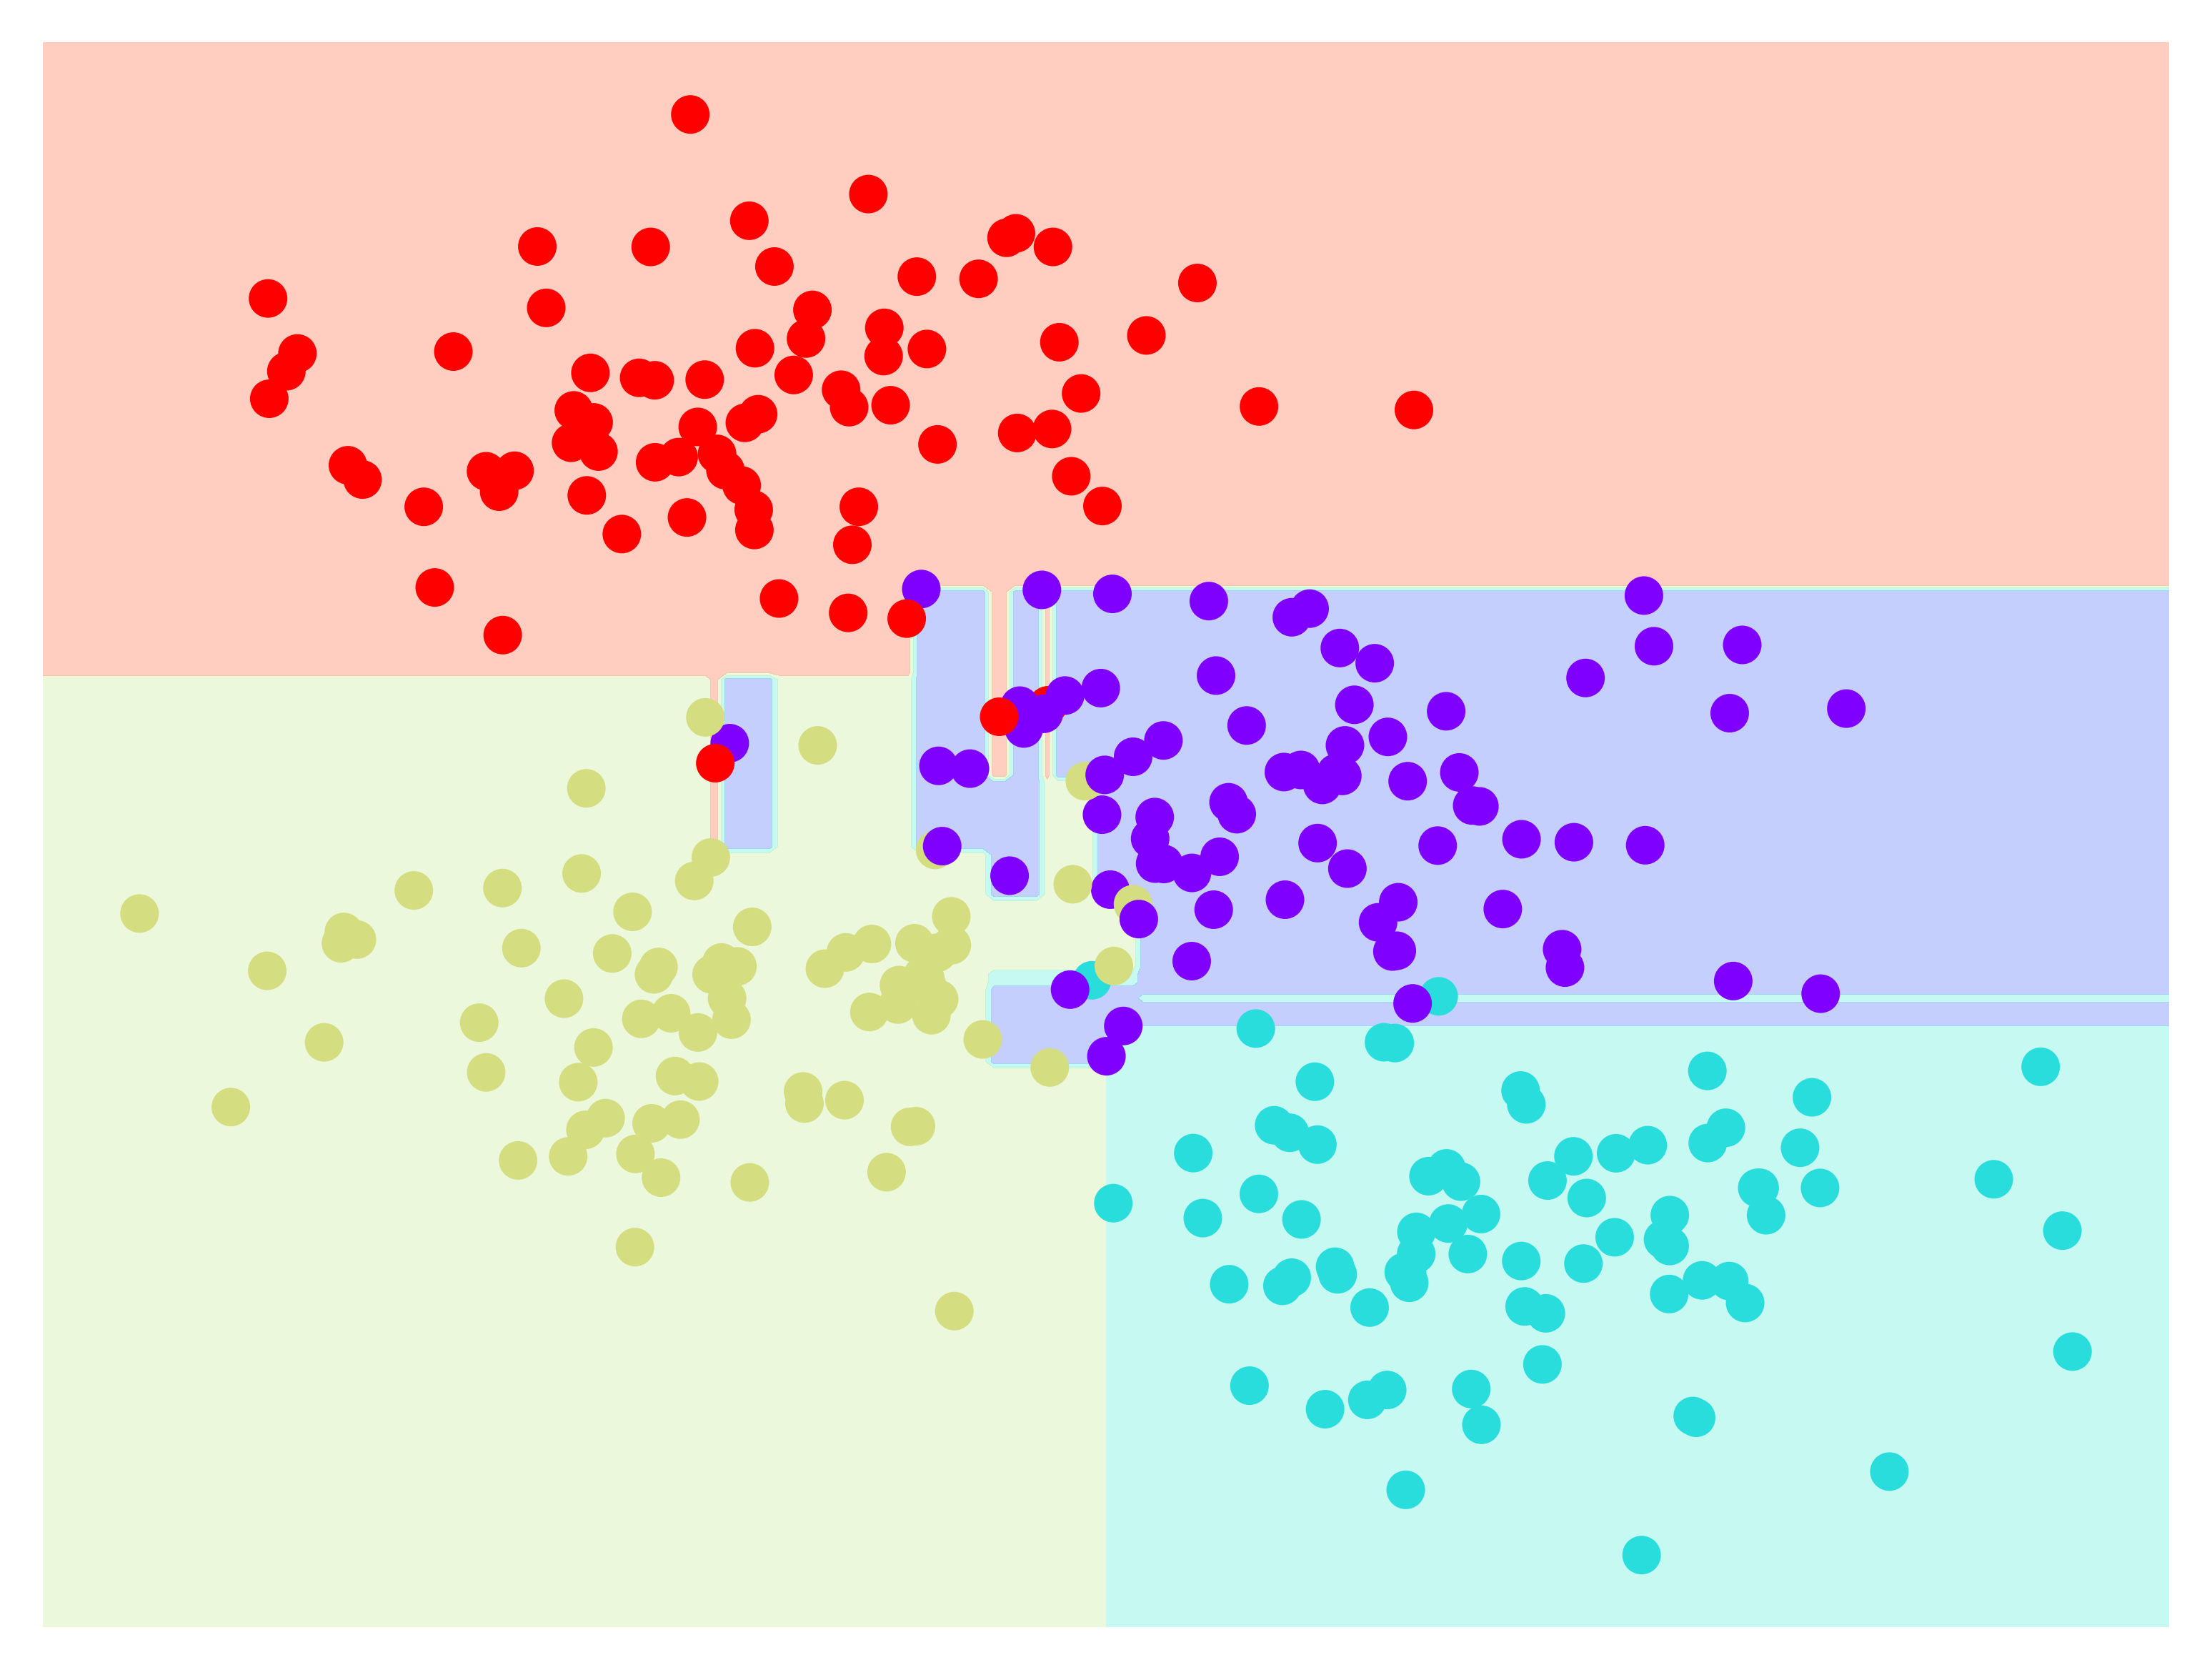

In [6]:
# now we can examine what the decision tree classification looks like:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [7]:
# this is the interactive visualization of the decsion tree classifier
helpers_05_08.plot_tree_interactive(X, y)
# as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five there is a tall and skinny purple region between the yellow and blue regions. It's clear that this is less a result of the true, intrinsic data distribution but rather an artifact of the particular sampling or noise properties of the data. That is, this decision tree, even at only five levels deep, is clearly over-fitting our data.

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

Decision Trees and Overfitting

In [8]:
# such overfitting turns out to be a general property of decision trees; it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.
# inconsistencies arise where the classification is less certain.
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

Ensembles of Estimators: Random Forests

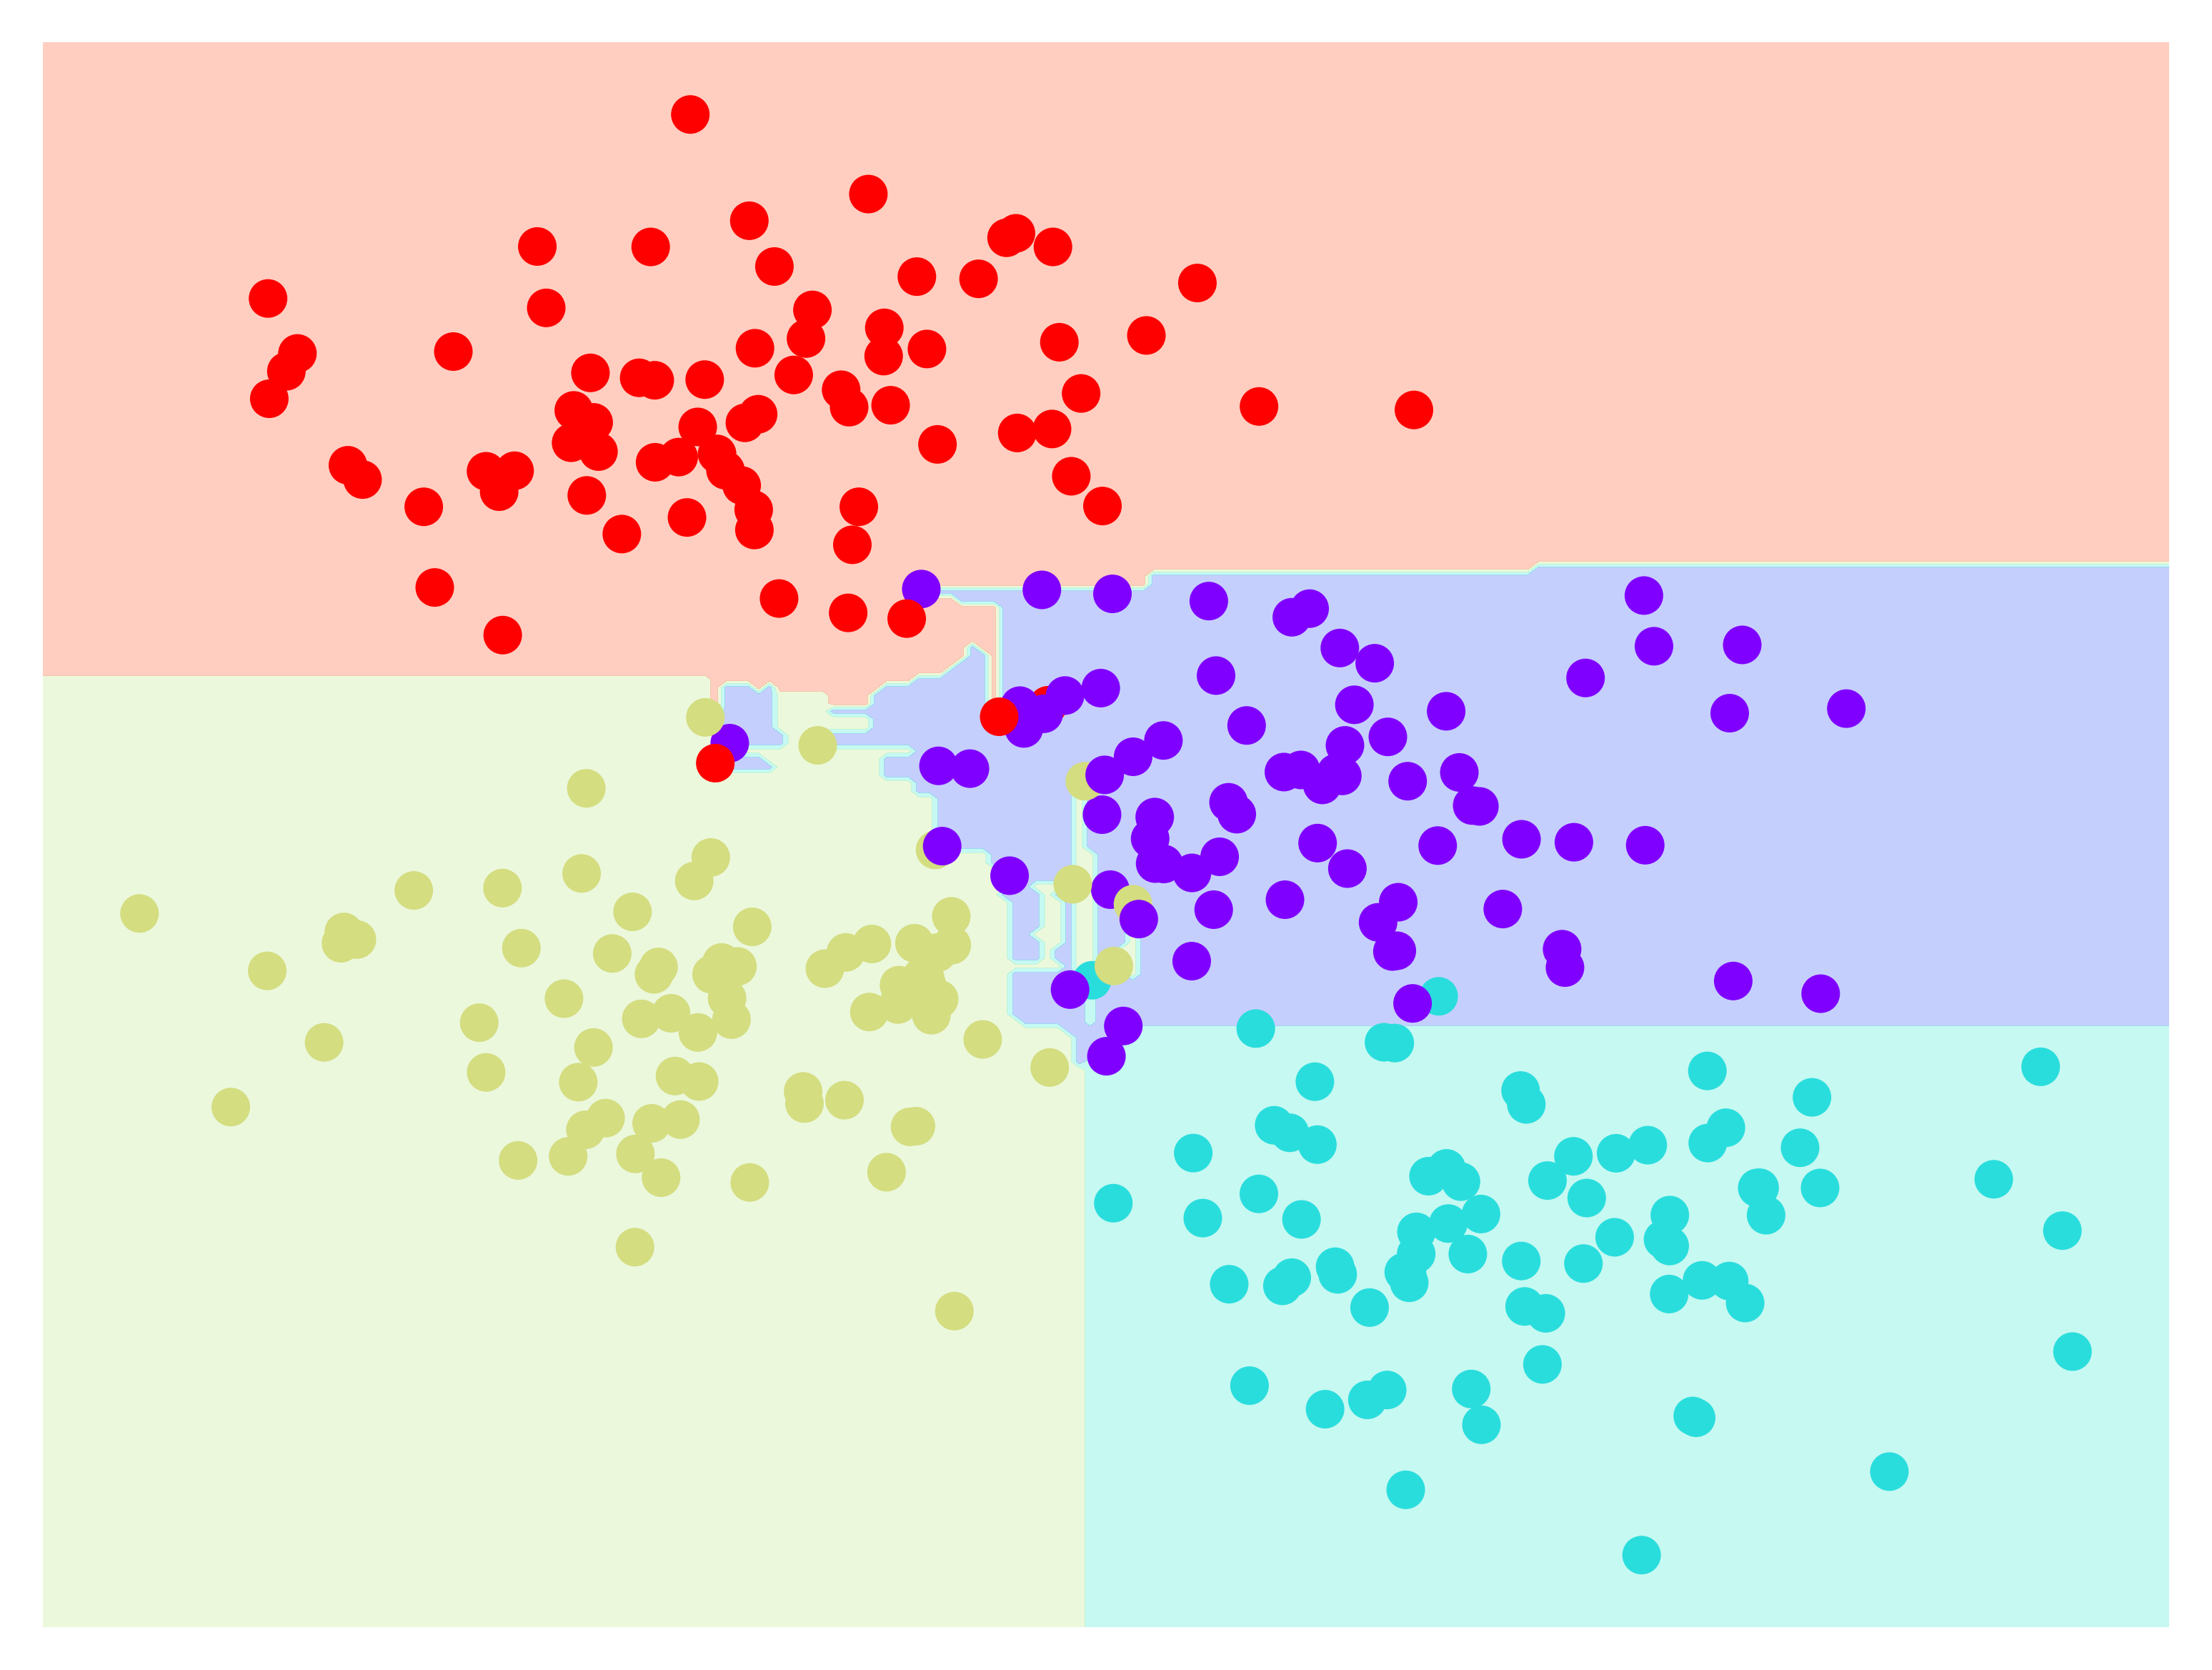

In [9]:
# this notion that multiple overfitting estimators can be combine to reduce the effect of this overfitting is what underlies an ensemble method called bagging. bagging makes use of an ensemble (a grab bag) of parallel estimators, each of which over-fits the data and averages the results to find a better classification. an ensemble of randomized decision trees is known as a random forest.
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)
bag.fit(X, y)
visualize_classifier(bag, X, y)

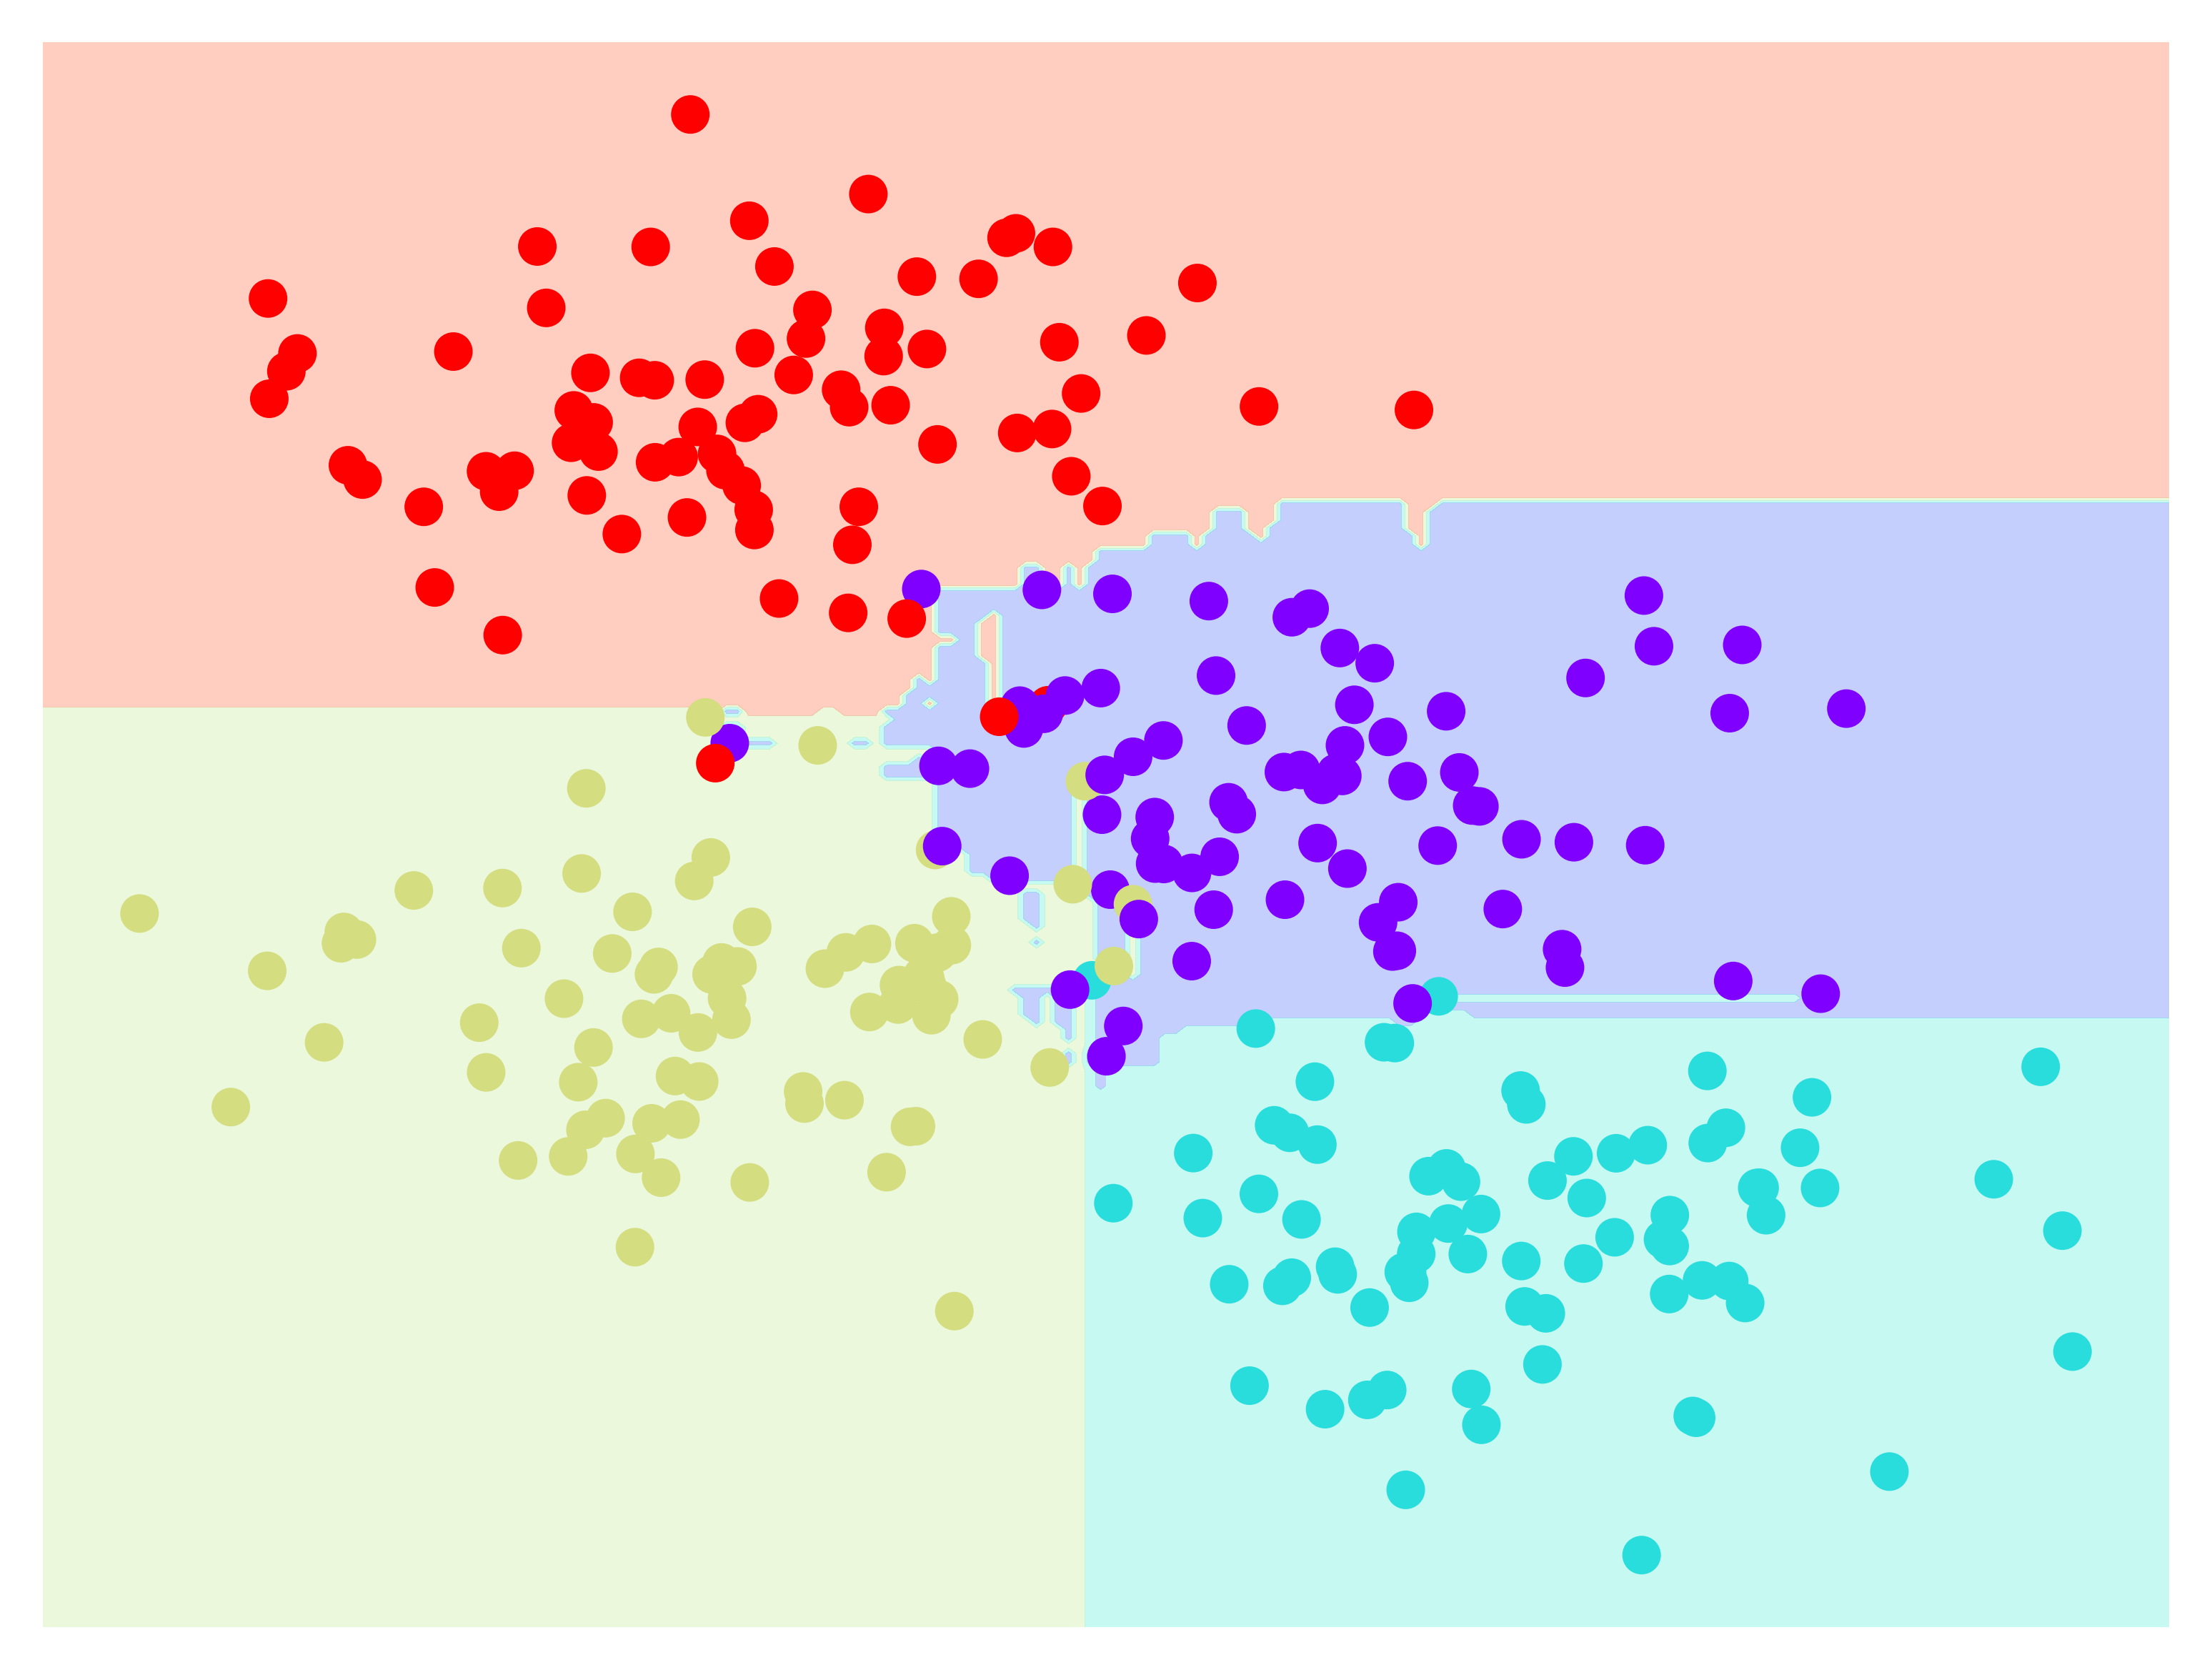

In [10]:
# in this example we have randomized the data by fitting each estimator with a random subset of 80% of the following points. in practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness. this is the idea behind randomized decision trees. in sklearn such an optimized ensemble of randomized decision trees is implemented in the RandomForestClassifier estimator, which takes care of all the randomization automatically.
model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y)
# this is a much more intuitive split of the classification space

Random Forest Regression

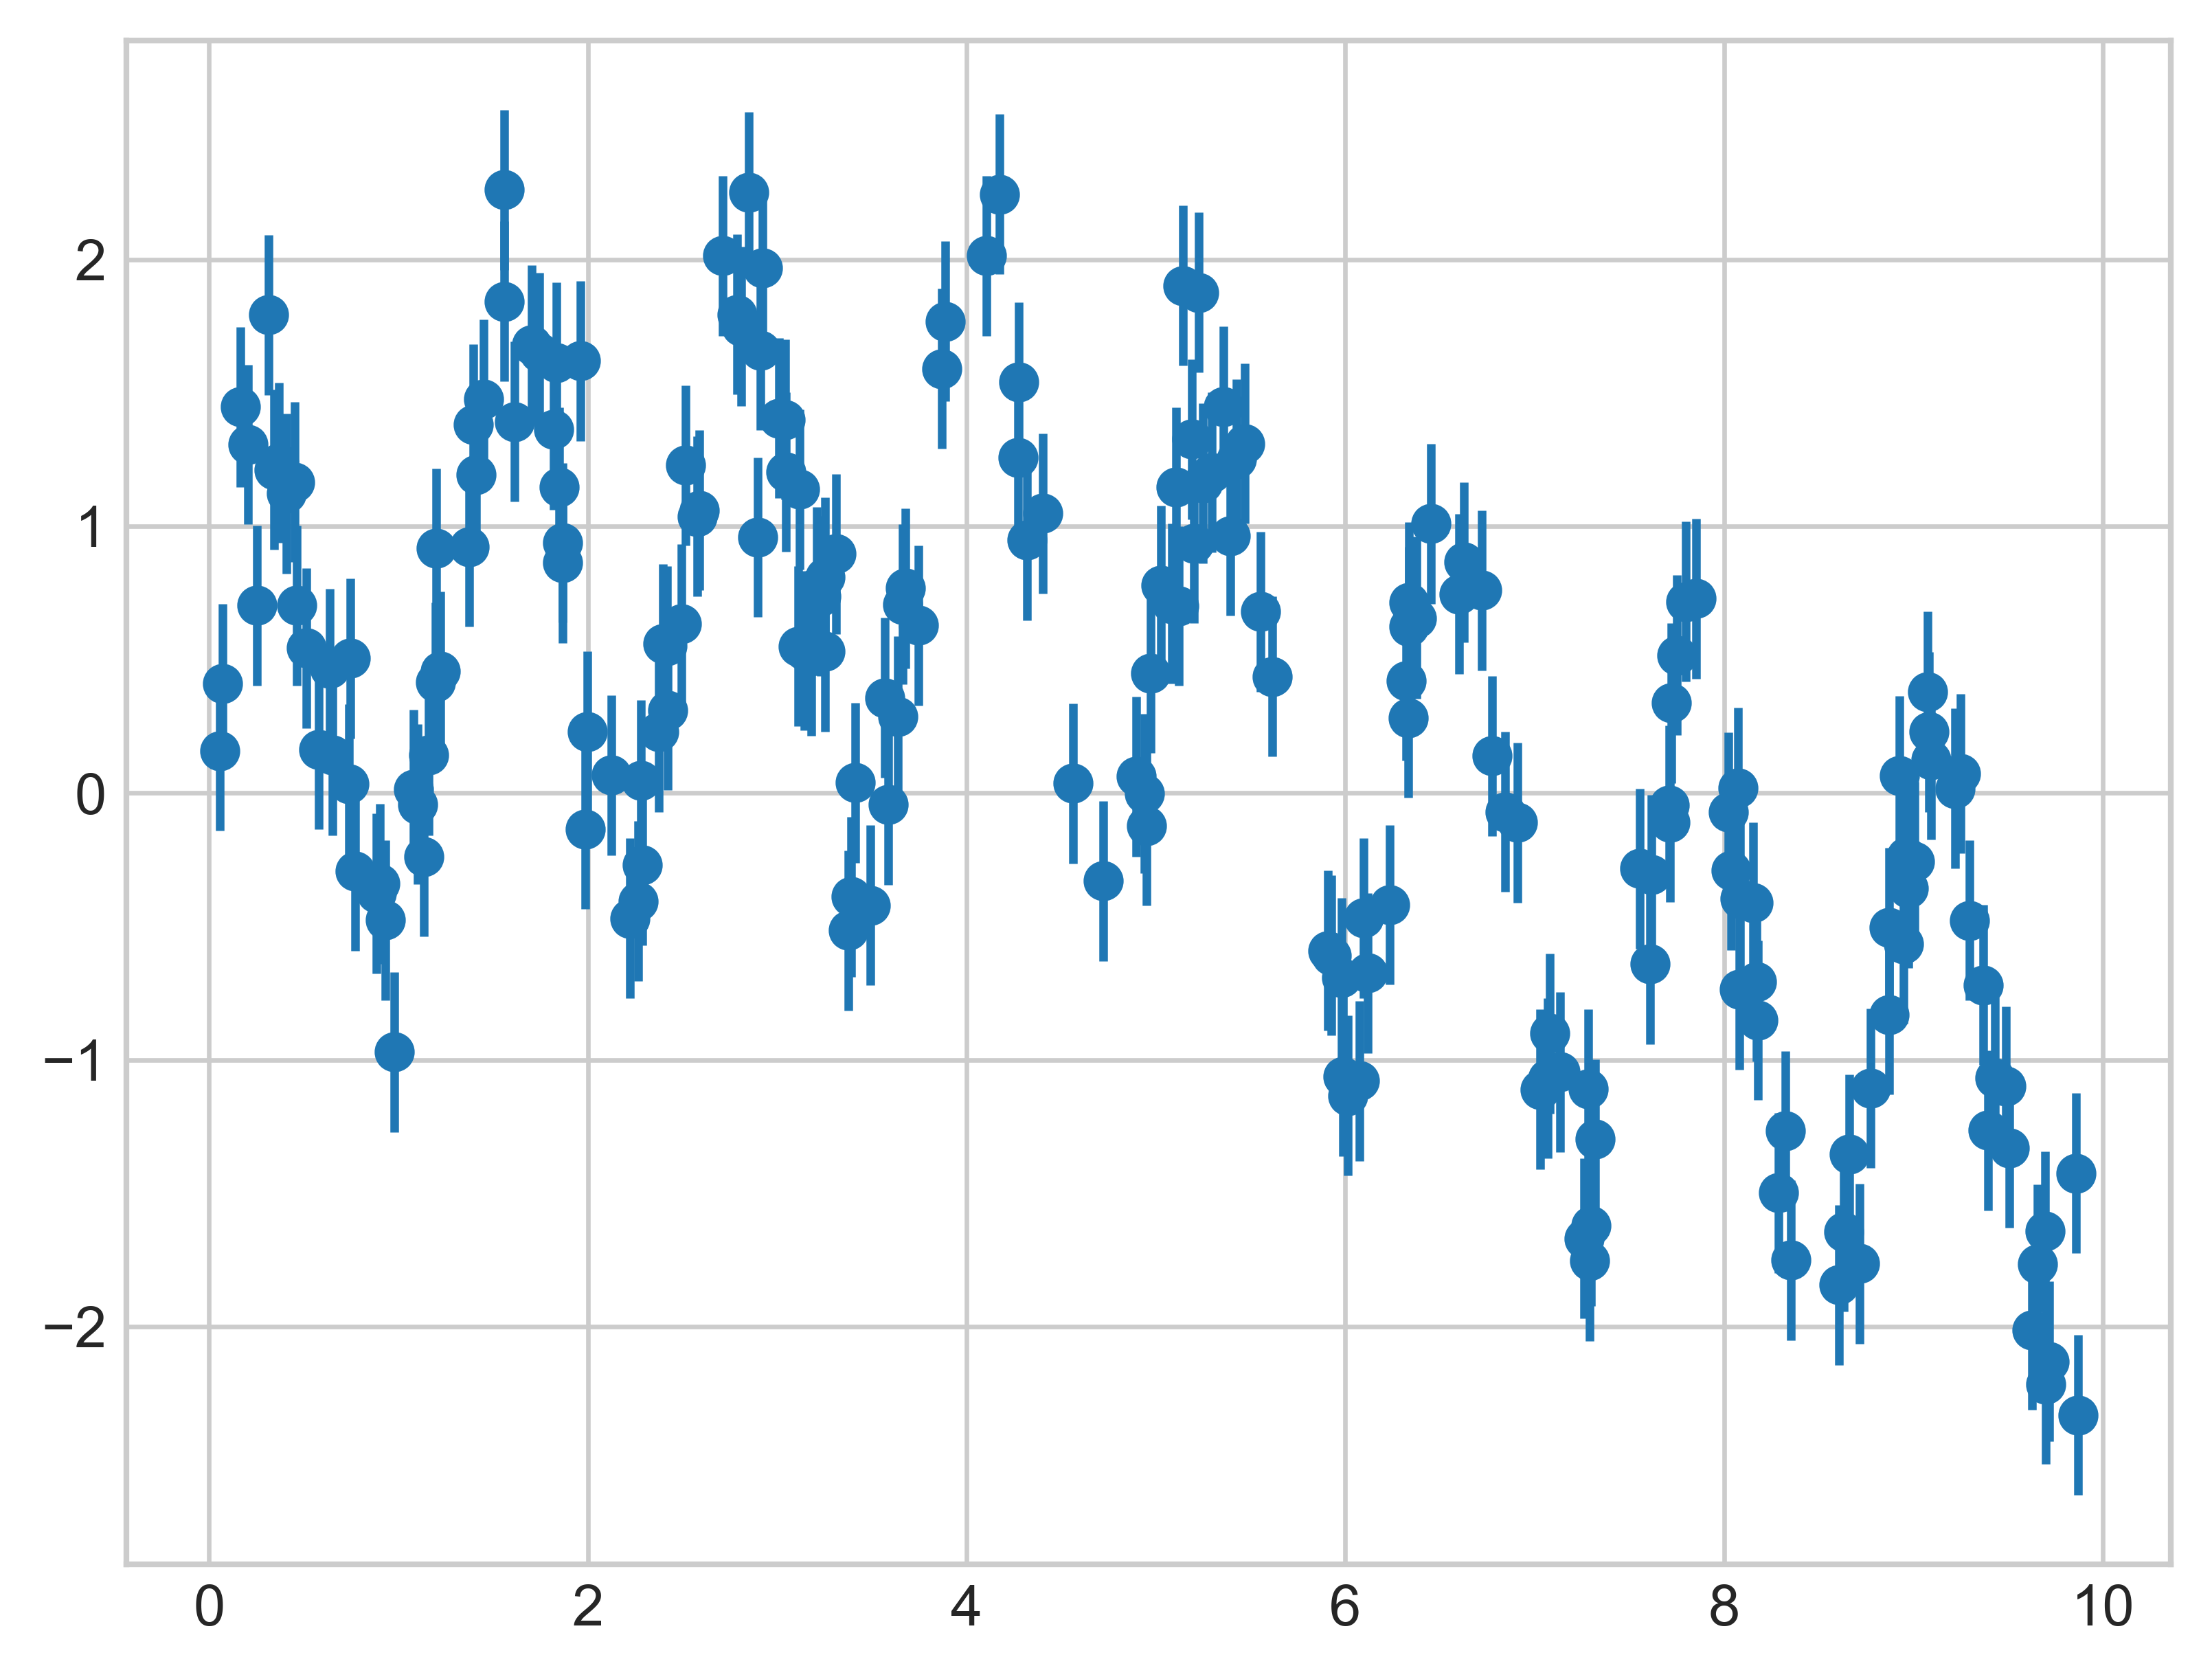

In [11]:
# in the previous section we considered random forest within the context of classification. Random forests can also be made to work int he case of regrssion that is continuous rather than discrete quantities. the estimator to use for this is the RandomForestRegressor, and the syntax is very similar to what we saw earlier.
# consider the following data, drawn from the combination of a fast and slow oscillation:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)


def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    return slow_oscillation + fast_oscillation + noise


y = model(x)
plt.errorbar(x, y, 0.3, fmt="o")

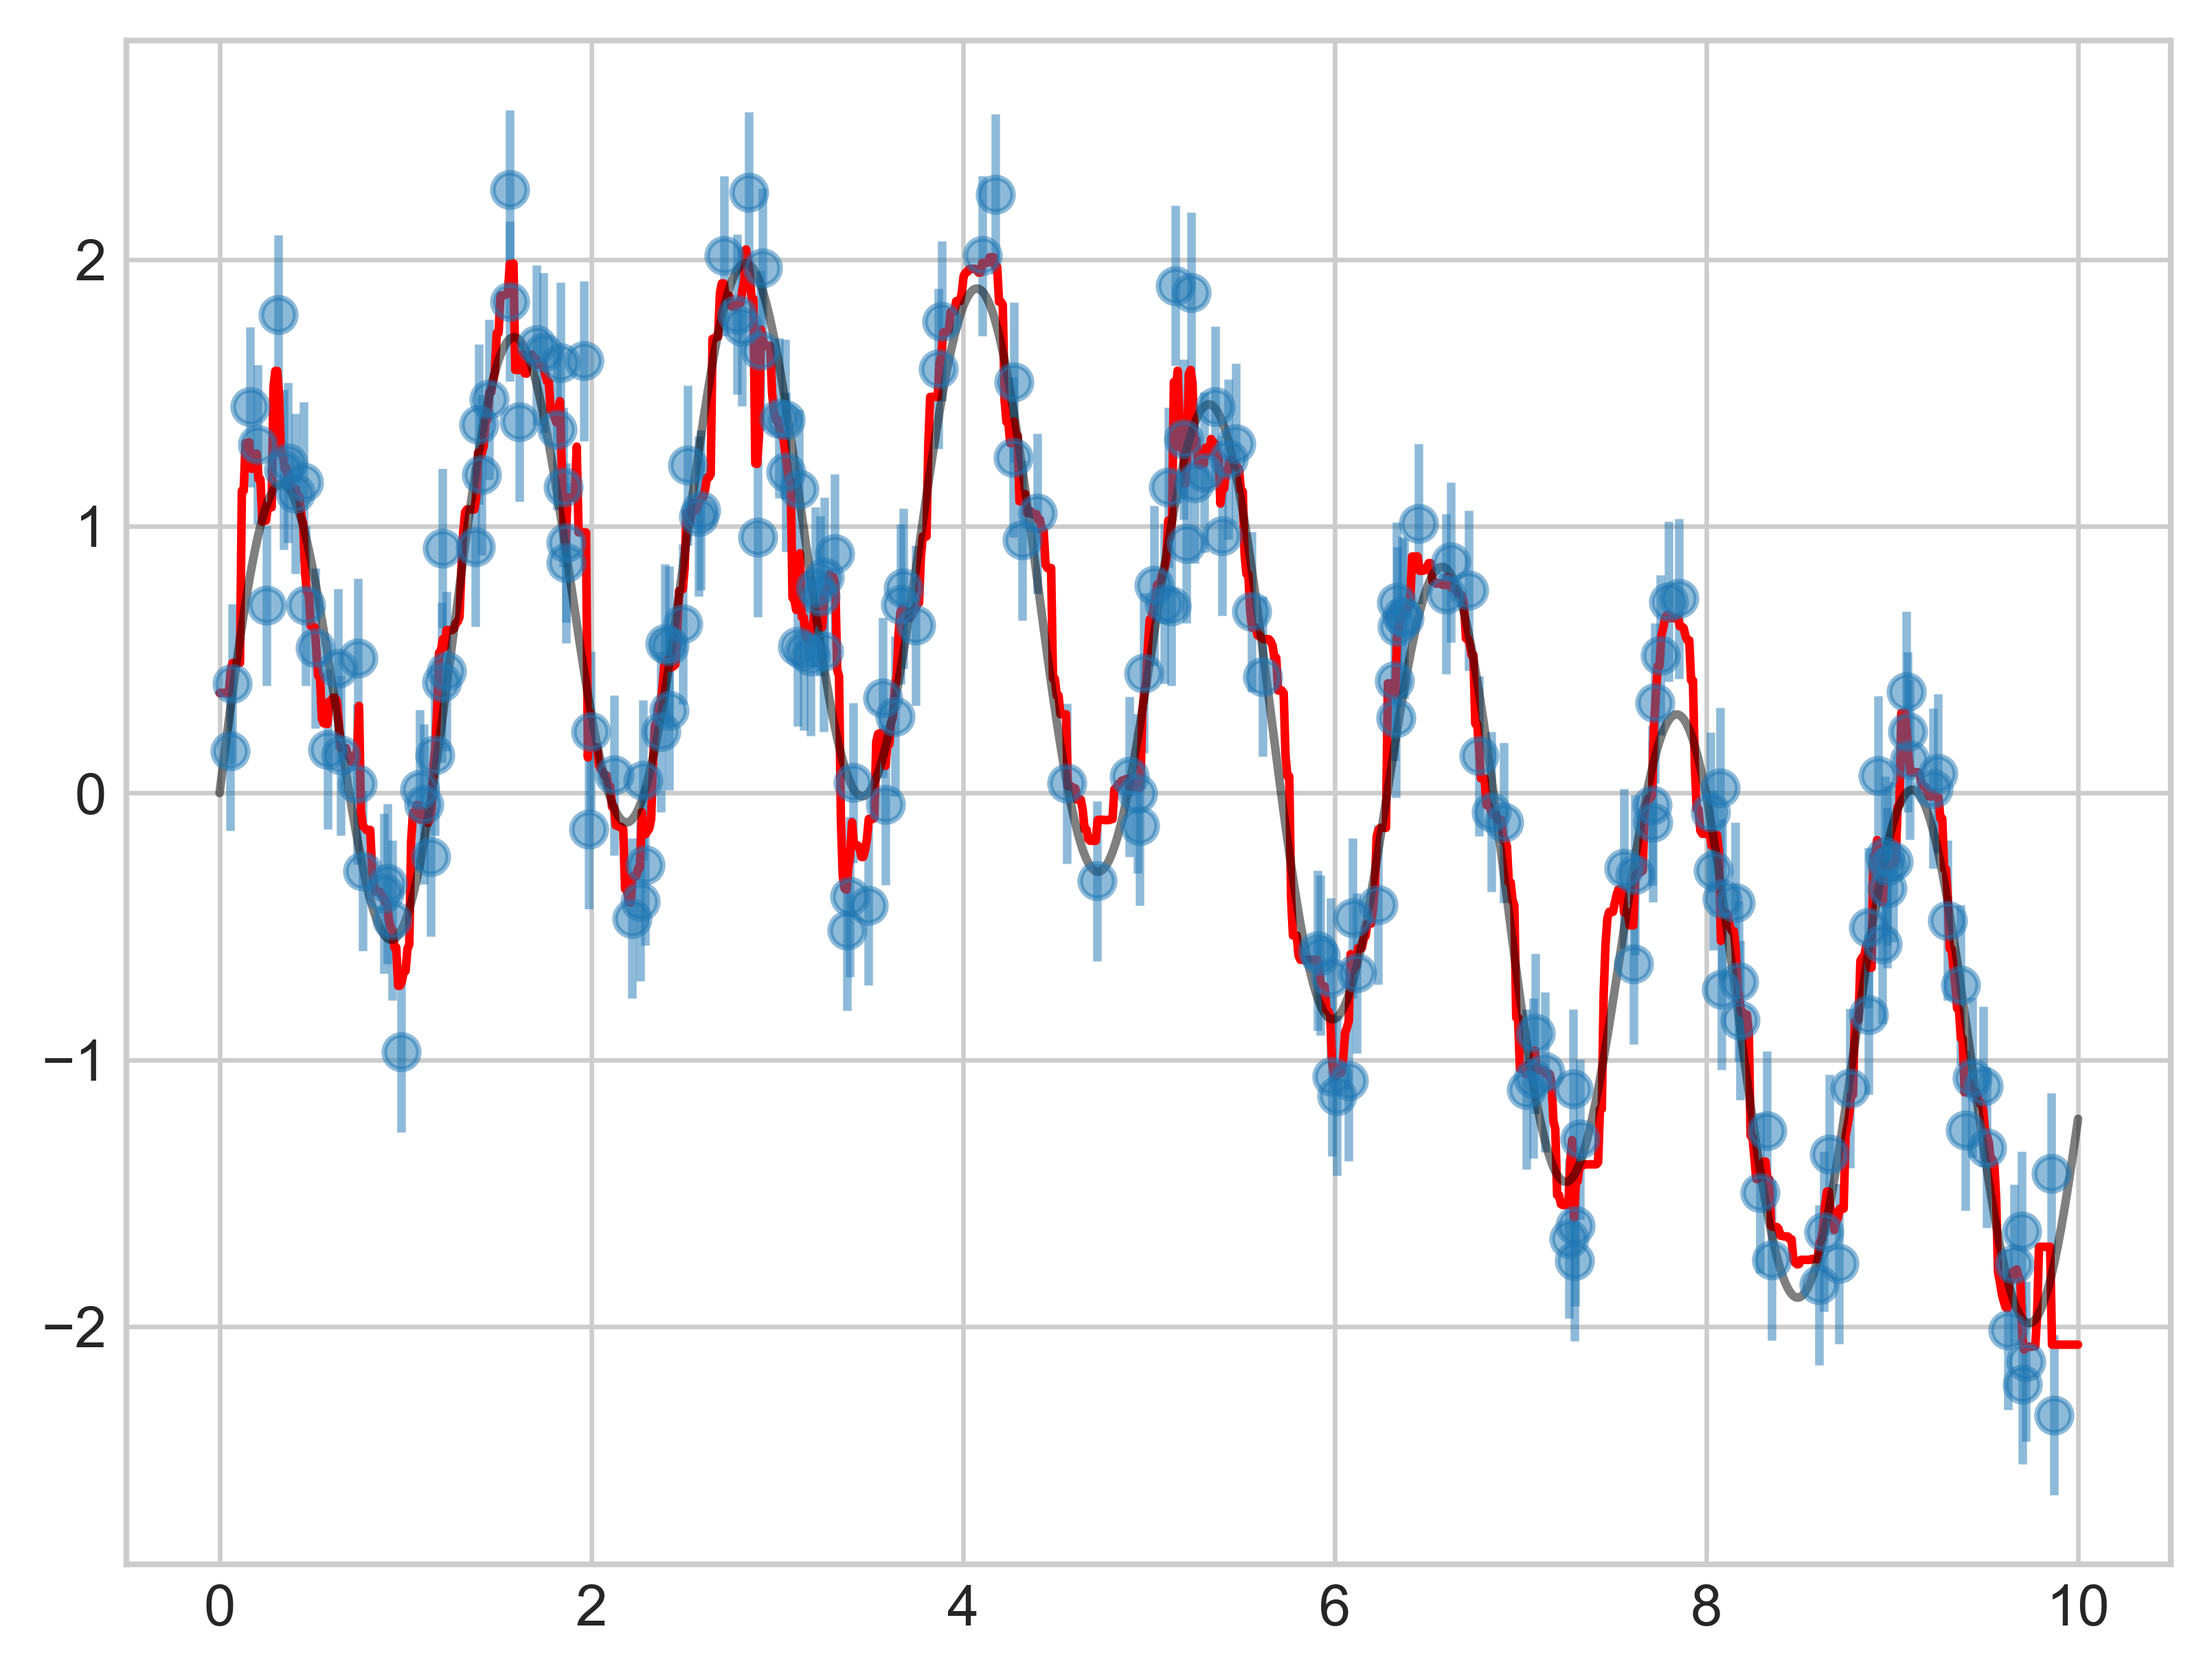

In [12]:
# using the random forest regressor, we can find the best fit curve as follows:
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt="o", alpha=0.5)
plt.plot(xfit, yfit, "-r")
plt.plot(xfit, ytrue, "-k", alpha=0.5)
# the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. the nonparametric random forest model is flexible enough to fit the multiperiod data, without us needing to specify a multi-period model.

Example: random forests for classifying digits

In [13]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

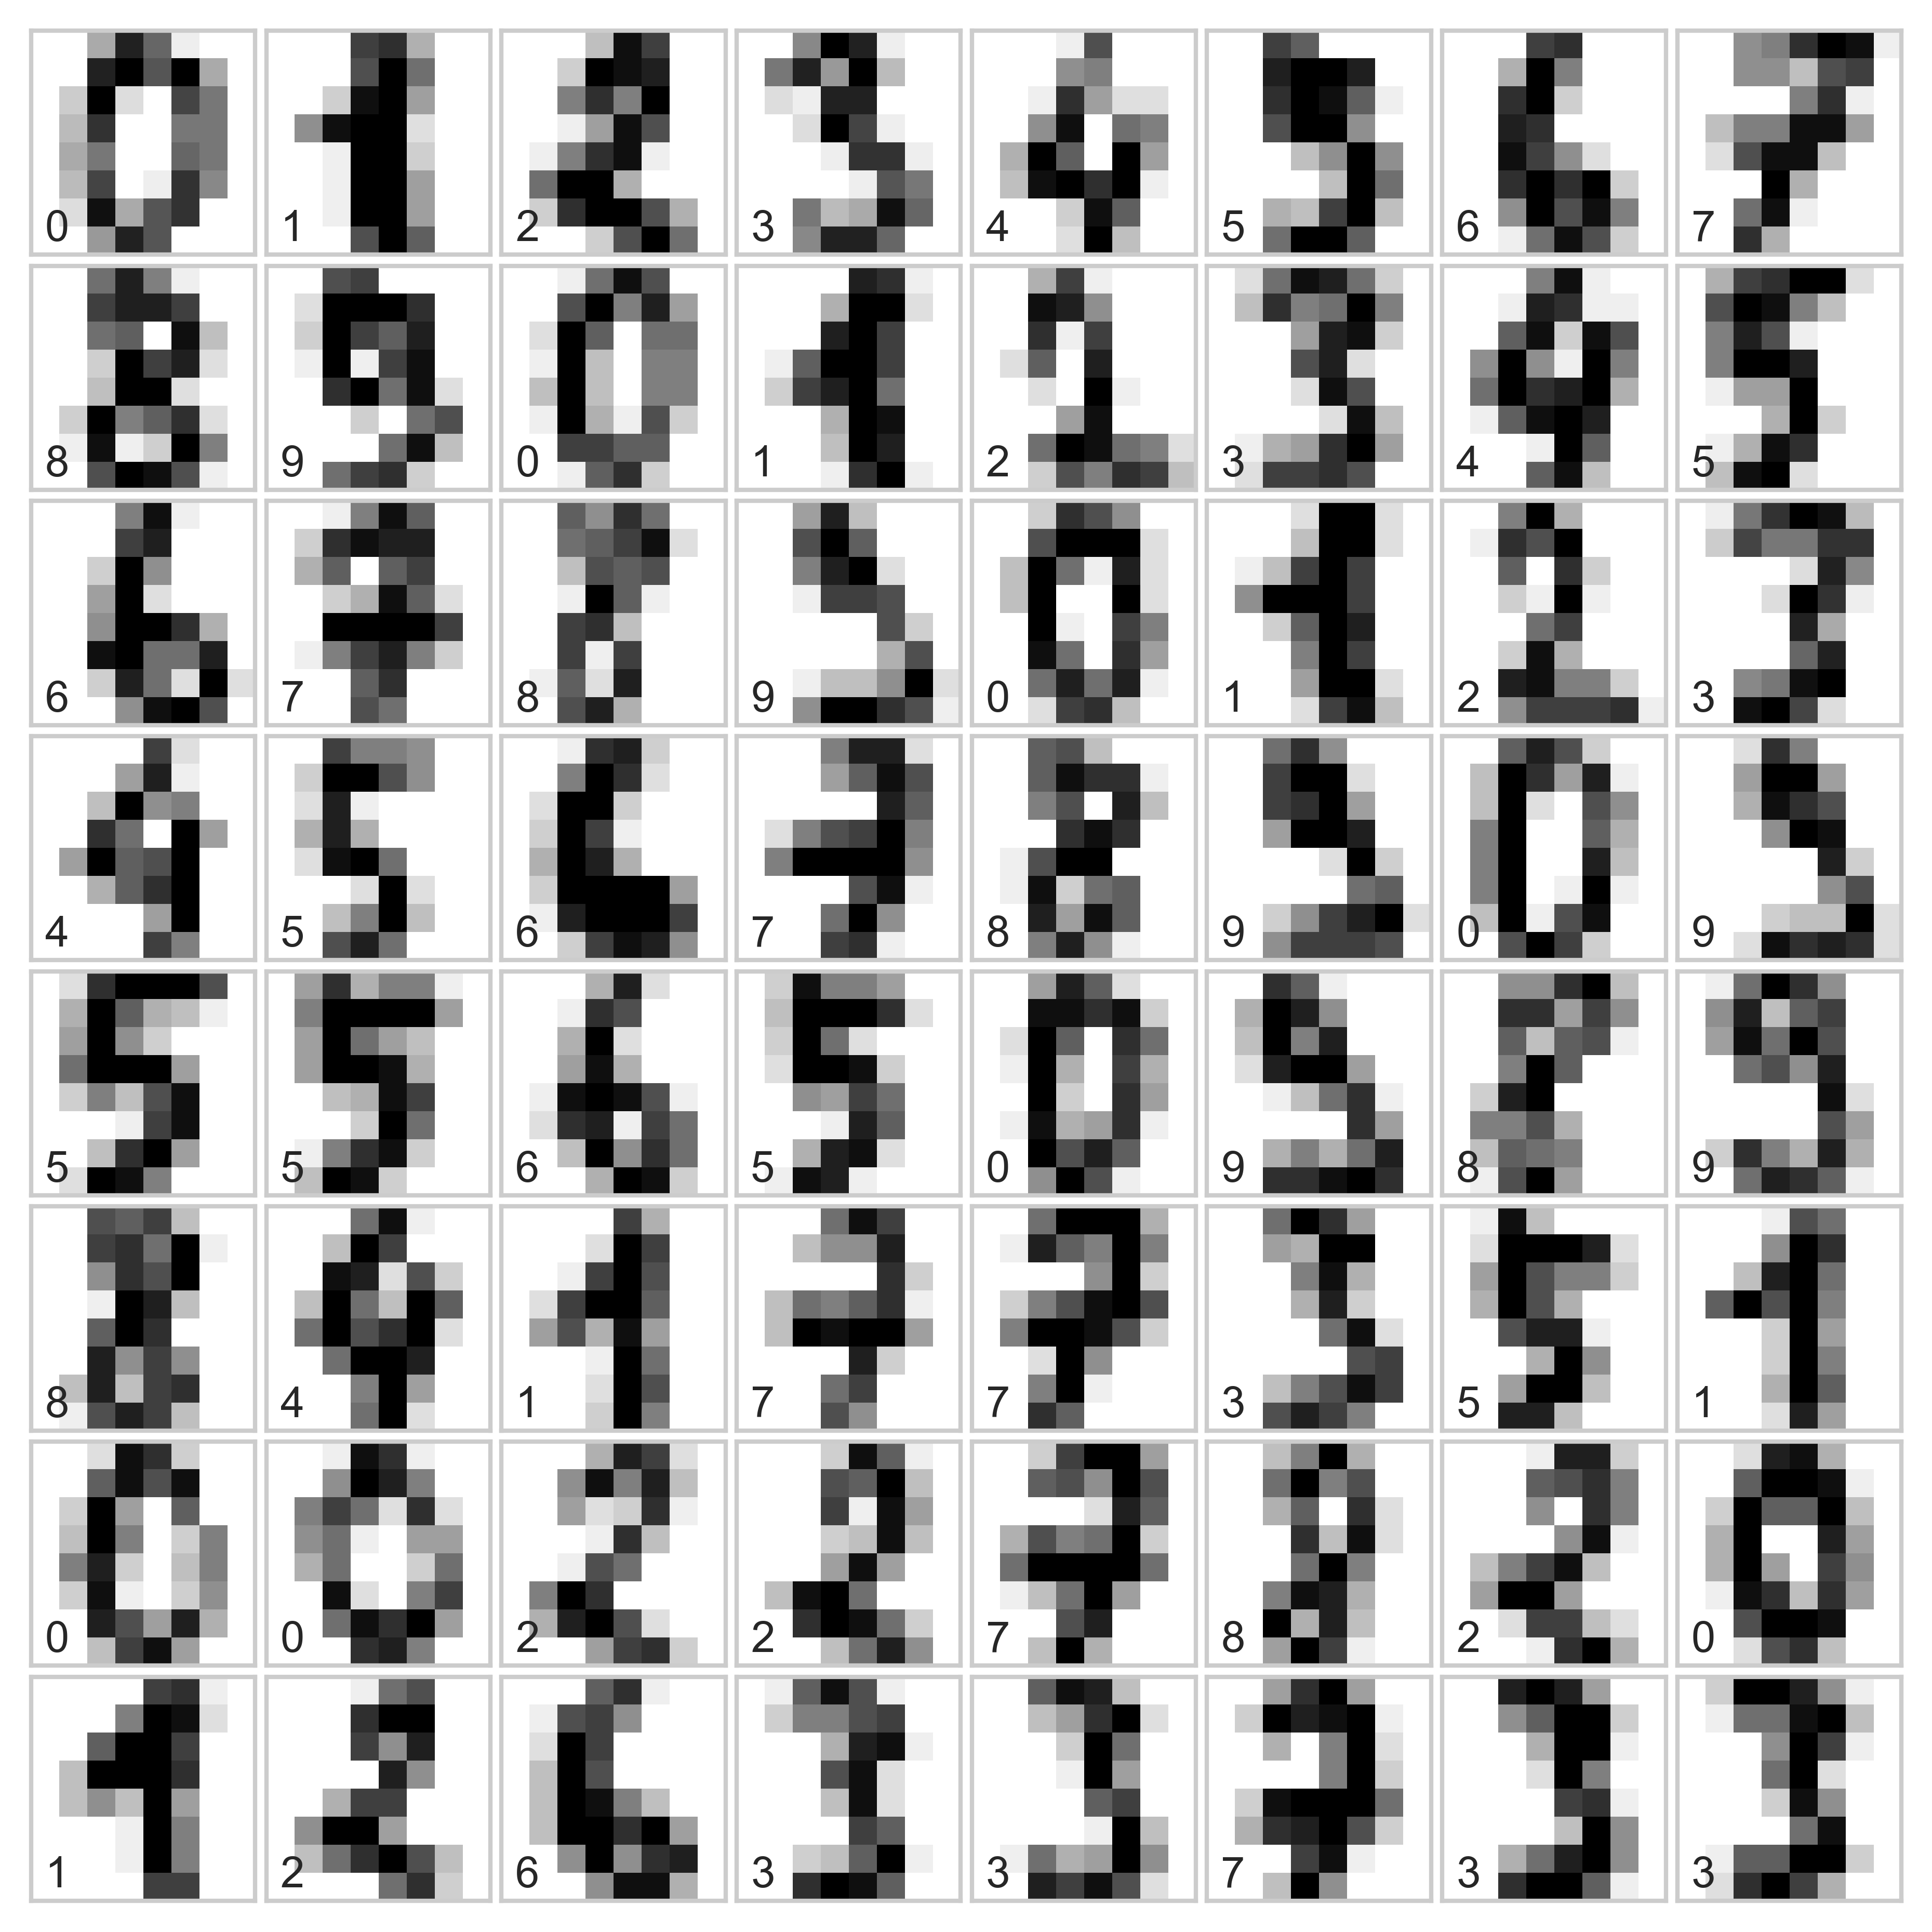

In [14]:
# we can quickly visualize the data to see what we're working with:
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation="nearest")
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [15]:
# we can classify the digits using a random forest.
Xtrain, Xtest, ytrain, ytest = train_test_split(
    digits.data, digits.target, random_state=0
)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [16]:
# we can look at the classification report for this classifier:
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



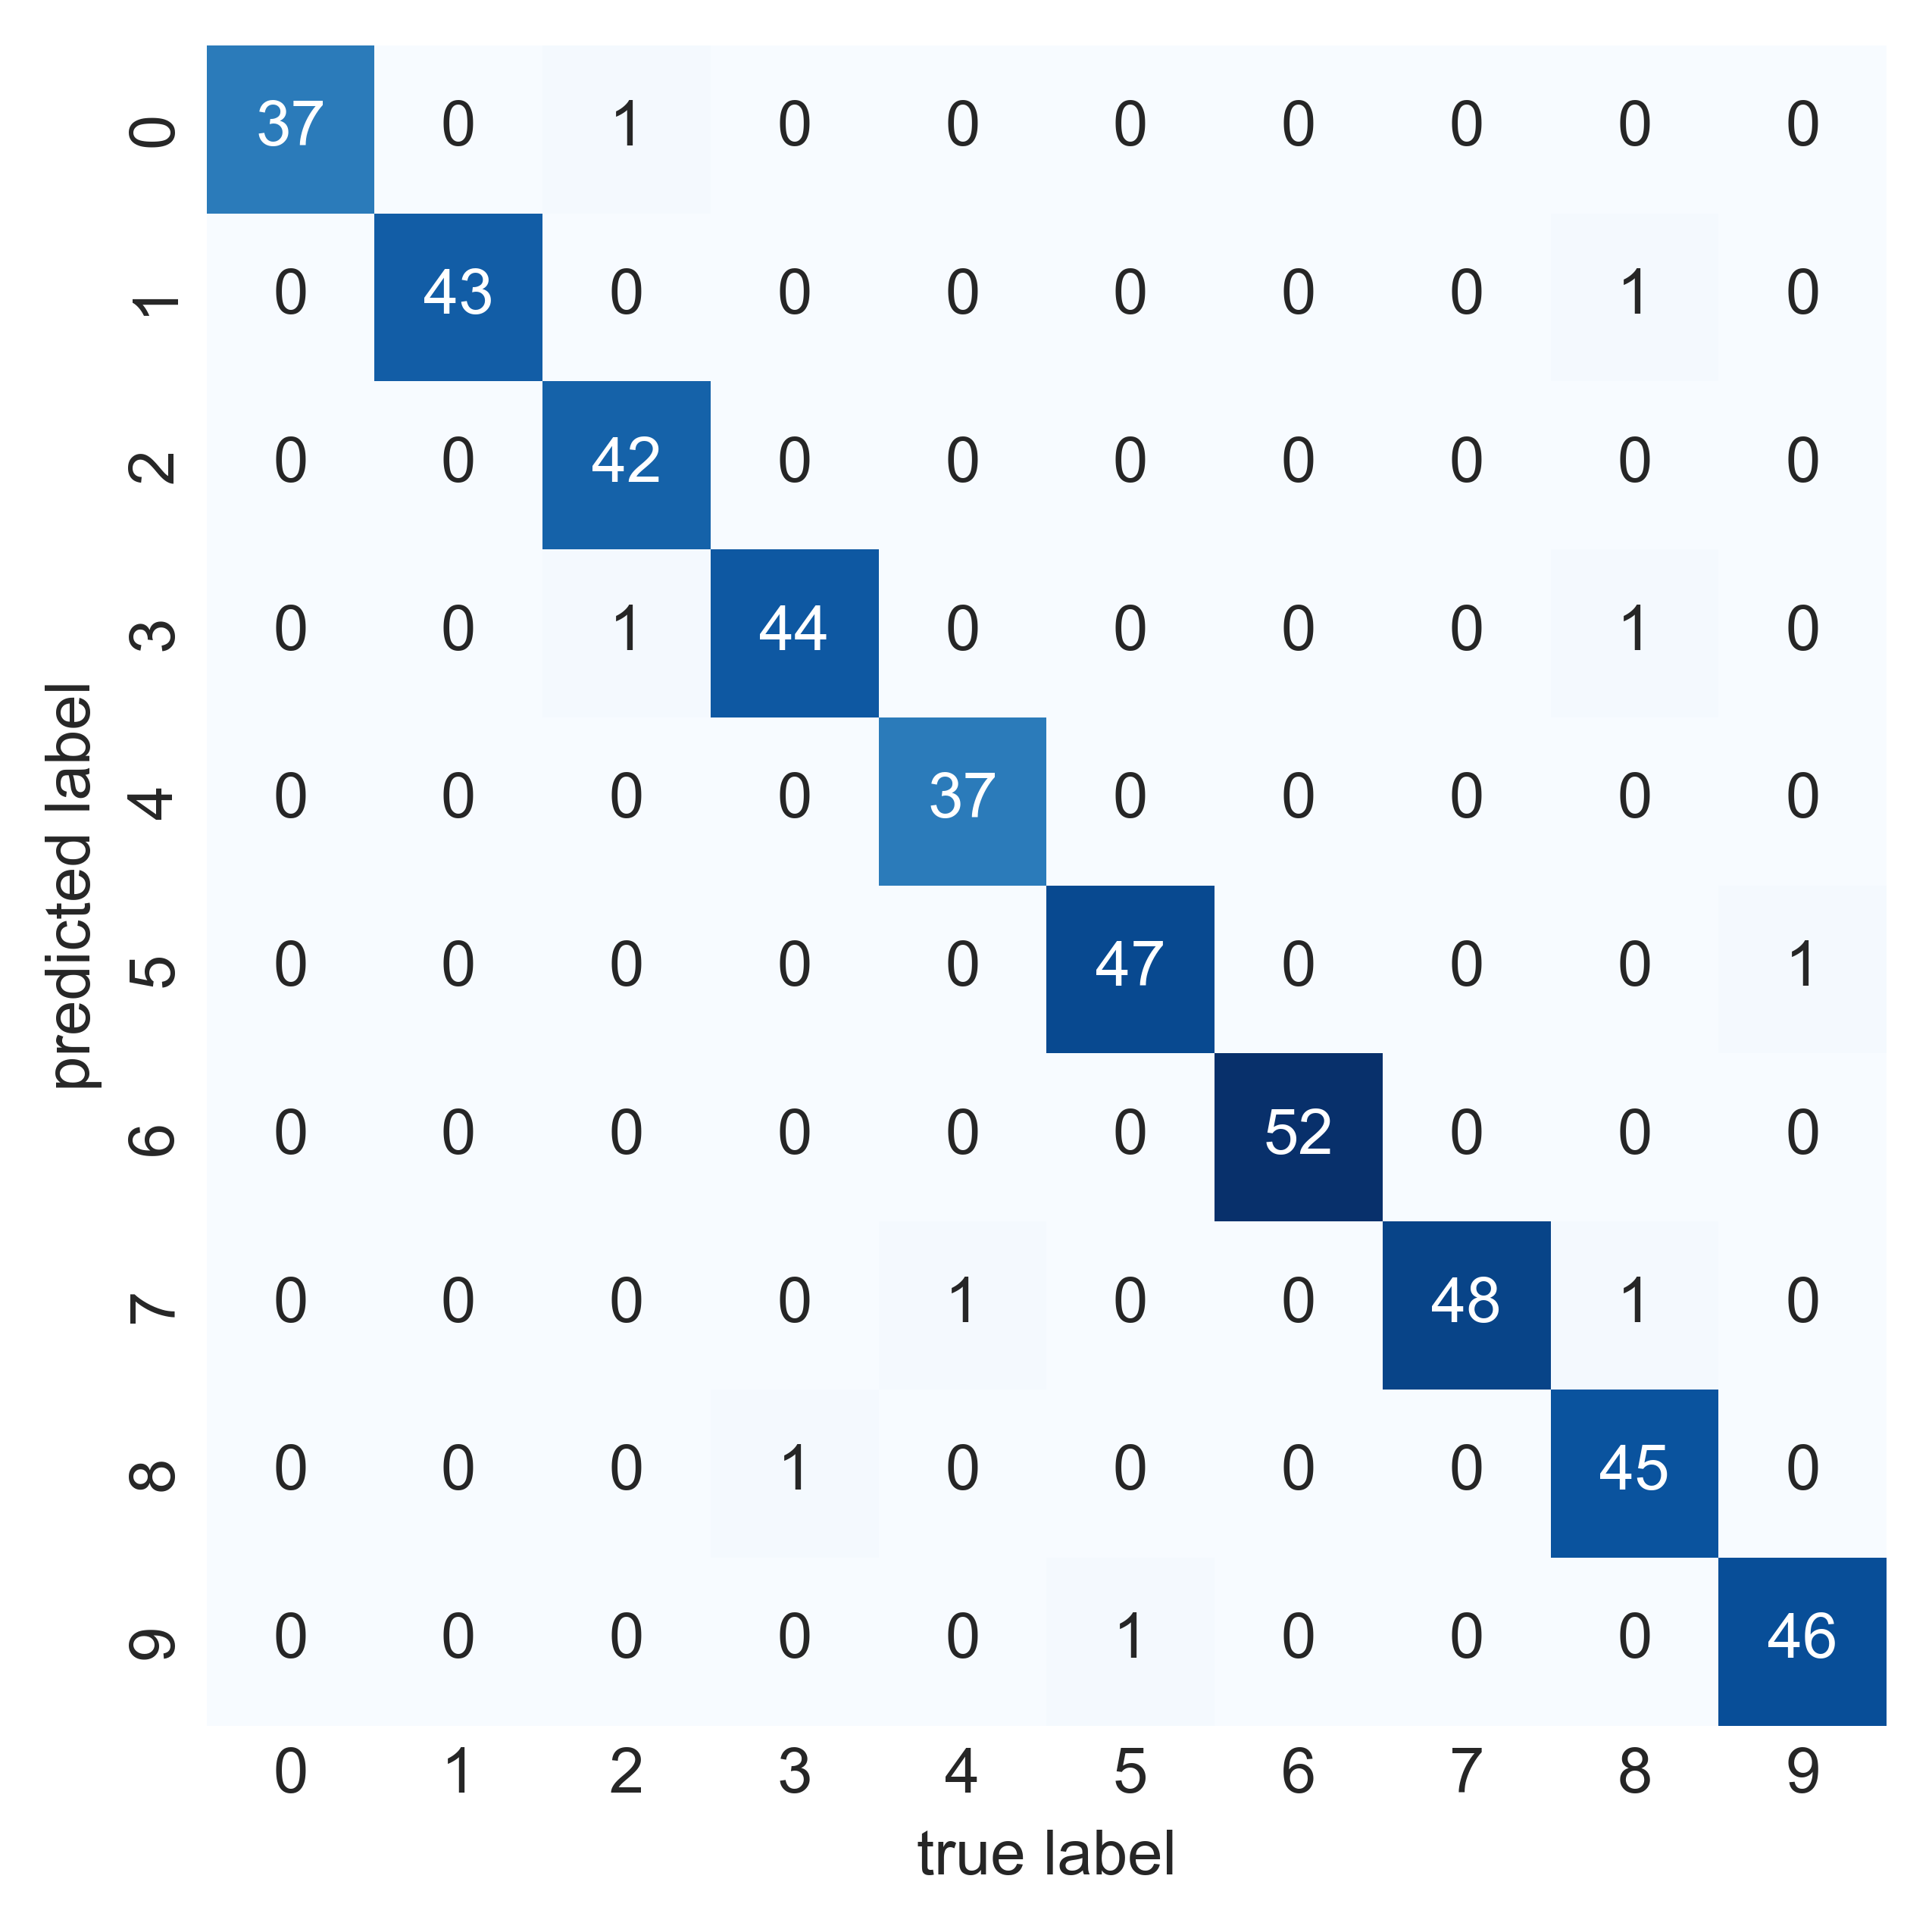

In [18]:
# and plot the confusion matrix between these values:
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt="d", cbar=False, cmap="Blues")
plt.xlabel("true label")
plt.ylabel("predicted label")